# Notebook 2 – Trader Leverage & Sentiment Deep-Dive
Use this notebook after running Notebook 1. It inspects the CSV outputs (rankings, clusters, regime metrics, leverage alerts) generated inside `ds_Advay_Sinha/csv_files`.


**What you can do here**
- Validate leverage and ROI behavior for each sentiment bucket.
- Merge rankings with cluster labels to craft qualitative notes.
- Produce extra charts or tables for the PDF/README if reviewers need visuals.


In [2]:
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print('Drive mounted. Update DATA_ROOT below if needed.')
except ModuleNotFoundError:
    print('Running outside Colab. Proceed to the next cell.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted. Update DATA_ROOT below if needed.


In [3]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')


In [4]:
DATA_ROOT = Path('/content/drive/MyDrive/ds_Advay_Sinha')
if not DATA_ROOT.exists():
    DATA_ROOT = Path.cwd()
CSV_DIR = DATA_ROOT / 'csv_files'
OUTPUT_DIR = DATA_ROOT / 'outputs'
print('Using data root:', DATA_ROOT)


Using data root: /content/drive/MyDrive/ds_Advay_Sinha


In [5]:
rankings = pd.read_csv(CSV_DIR / 'trader_rankings.csv')
clusters = pd.read_csv(CSV_DIR / 'trader_behavior_clusters.csv')
regime_metrics = pd.read_csv(CSV_DIR / 'trader_regime_metrics.csv')
leverage_alerts = pd.read_csv(CSV_DIR / 'leverage_alerts.csv')
model_metrics = pd.read_json(CSV_DIR / 'model_metrics.json')
strategy_metrics = pd.read_json(CSV_DIR / 'strategy_metrics.json')
print('Rankings:', rankings.shape, '| Clusters:', clusters.shape)


Rankings: (32, 6) | Clusters: (32, 3)


In [6]:
rankings_clusters = rankings.merge(clusters, on='account', how='left')
rankings_clusters.head()


,account,roi,closed_pnl,abs_leverage,win_rate,composite_score,kmeans_cluster,dbscan_cluster
0,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,0.276064,72846.484272,3.576753,0.573141,0.93125,0,-1
1,0x430f09841d65beb3f27765503d0f850b8bce7713,0.134140,416541.872341,0.437054,0.484236,0.91250,0,-1
2,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,0.027667,379095.406711,3.567088,0.810876,0.80000,0,-1
3,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.023537,168658.004994,3.395513,0.519914,0.76875,0,0
4,0xbaaaf6571ab7d571043ff1e313a9609a10637864,0.013435,940163.806220,0.216096,0.467582,0.70625,0,0


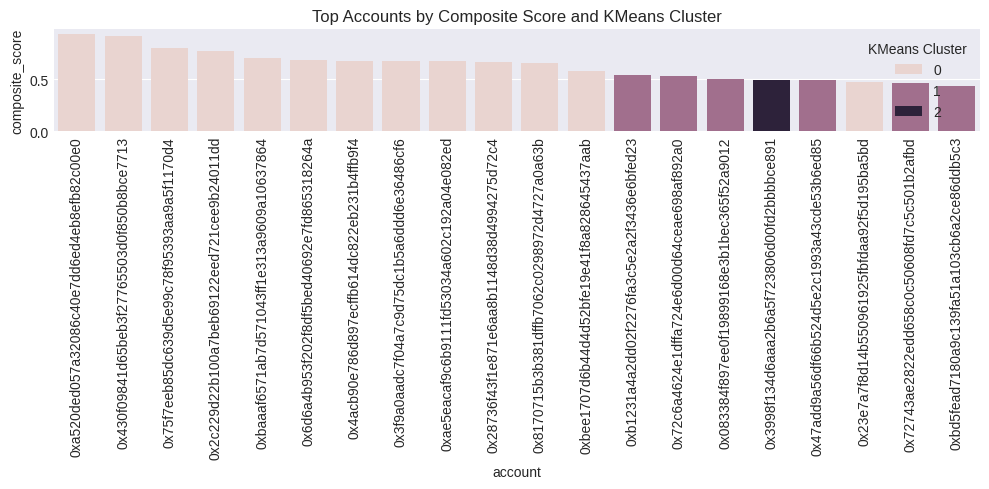

In [7]:

plt.figure(figsize=(10, 5))
top_accounts = rankings_clusters.head(20)
sns.barplot(data=top_accounts, x='account', y='composite_score', hue='kmeans_cluster')
plt.xticks(rotation=90)
plt.title('Top Accounts by Composite Score and KMeans Cluster')
plt.legend(title='KMeans Cluster')
plt.tight_layout()
plt.show()


In [8]:

dbscan_counts = (
    clusters['dbscan_cluster']
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={'index': 'dbscan_cluster', 'dbscan_cluster': 'account_count'})
)
dbscan_counts


,account_count,count
0,0,21
1,-1,11


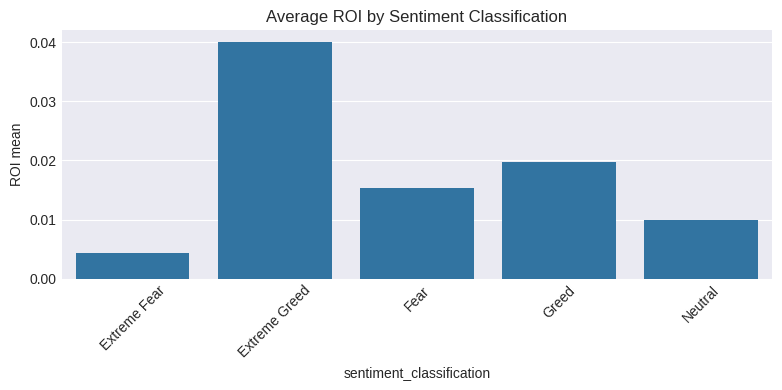

In [9]:
plt.figure(figsize=(8, 4))
sns.barplot(data=regime_metrics, x='sentiment_classification', y='roi_mean')
plt.title('Average ROI by Sentiment Classification')
plt.ylabel('ROI mean')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


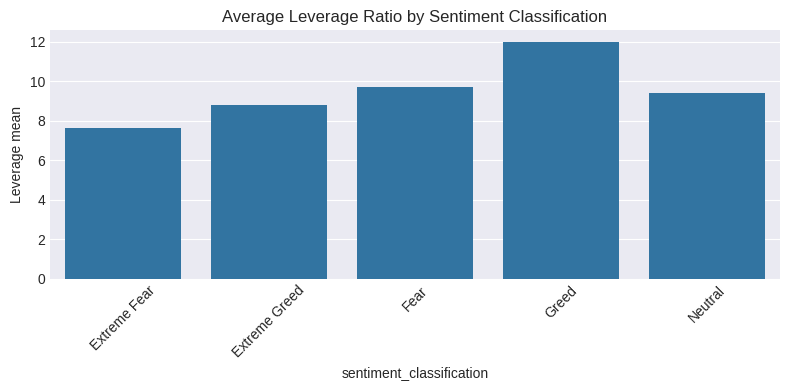

In [10]:
plt.figure(figsize=(8, 4))
sns.barplot(data=regime_metrics, x='sentiment_classification', y='abs_leverage_mean')
plt.title('Average Leverage Ratio by Sentiment Classification')
plt.ylabel('Leverage mean')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


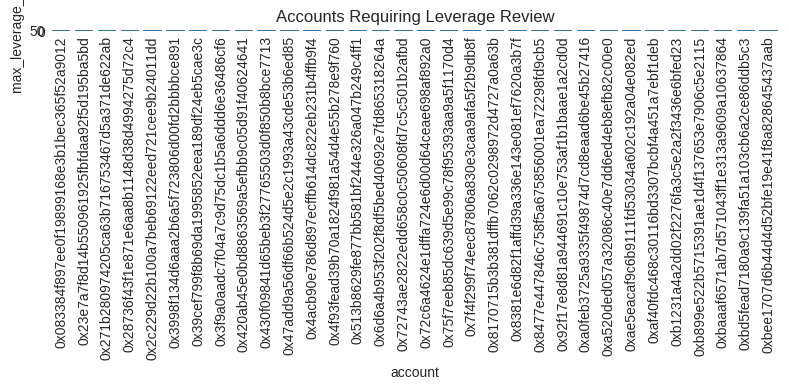

In [11]:
plt.figure(figsize=(8, 4))
if not leverage_alerts.empty:
    sns.barplot(data=leverage_alerts.sort_values('max_leverage_ratio', ascending=False), x='account', y='max_leverage_ratio')
    plt.xticks(rotation=90)
    plt.title('Accounts Requiring Leverage Review')
    plt.tight_layout()
else:
    print('No leverage alerts were triggered.')


In [12]:
model_metrics.T


,accuracy,f1,roc_auc,confusion
LogisticRegression,0.589193,0.035209,0.574147,"[[36861, 446], [25586, 475]]"
RandomForest,0.802803,0.712299,0.904971,"[[35403, 1904], [10592, 15469]]"
GradientBoosting,0.694515,0.52491,0.765954,"[[33316, 3991], [15367, 10694]]"
XGBoost,0.813818,0.750064,0.908253,"[[33867, 3440], [8358, 17703]]"


In [13]:
strategy_metrics.T


,Sharpe,Sortino,Profit Factor,Expectancy
Trend Following,0.137910,0.061898,1.705615,0.007320
Contrarian Extremes,-0.134869,-0.522797,0.352957,-0.007138
Leverage Scaling,0.143134,0.064288,1.653859,0.007610
